# Homework # 3: Neural Networks
Members: Jack Hanke, Daniel Plotkin, Hanna Zelis, Nicole Birova, & Vrishani Shah

Due: November 19

In [3]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting and data reading utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T
    # changed to added ones to allign with label data
    # temp = np.ones((data.shape[0], 1))
    # data = np.hstack((data, temp))

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            # pl = torch.argmax(pl, dim=1)
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")


def read_data(name, mode):
    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    # xs = np.array(x_data,dtype='float32')
    # ys = np.array(y_data,dtype='float32')
    # labels = np.array(label_data,dtype='float32')
    xs = torch.Tensor(x_data)
    ys = torch.Tensor(y_data)
    labels = torch.Tensor(label_data)
    return(xs,ys,labels)

## Question 1. PyTorch Implementation with MCE (2.0 points)

Implement and train a FFNN as specified above using PyTorch and multi-class cross entropy as the cost function. Experiment with each of the four datasets to find the best number of nodes $k$ from $\{2, 3, 5, 7, 9\}$ in the hidden layer. For the best $k$ for *each* dataset:

a. list hyper-parameters used in the model,

b. plot the learning curves for training and validation loss as a function of training epochs,

c. provide the final test accuracy, defined as the number of correct classifications divided by the total number of examples,

d. plot the learned decision surface along with observations from the test set (see example below), and

e. discuss your design choices and comment on how they impact performance

## Responses to Question 1

For sub-question *a*, the number of hidden neurons `k` was tested on $\{2, 3, 5, 7, 9\}$, and `k=9` preformed the best on all datasets.  Additionally, all datasets use a `learning_rate` of `0.01` and a `batch_size` of `5` for training. The `num_epochs` varies based on how quickly performance on the validation stops improving. 

For sub-questions *b*, *c*, and *d*, please view the output of the below code cell. All output for each dataset is properly marked and printed out. 

For sub-question *e*, the `k=9` hidden neurons network was chosen as the best for each dataset. Note that for the `xor` and `two_gaussians` dataset, the learning curves for `k=7` and `k=9` are similar, but eventually the two networks converge to the same minimal cost. 

- For the `xor` dataset, the number of epochs is set to `400`.
- For the `center_surround` dataset, the number of epochs is set to `100`.
- For the `two_gaussians` dataset, the number of epochs is set to `150`.
- For the `spiral` dataset, the number of epochs is set to `600`.


Beginning modelling for the xor dataset...


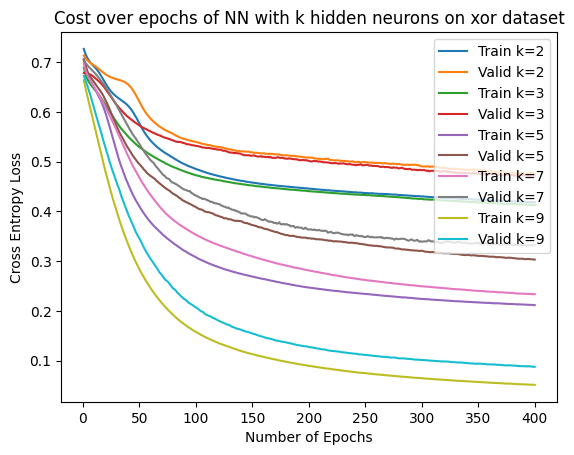

Test accuracy for xor dataset for NN with k=9 is 99.00%.


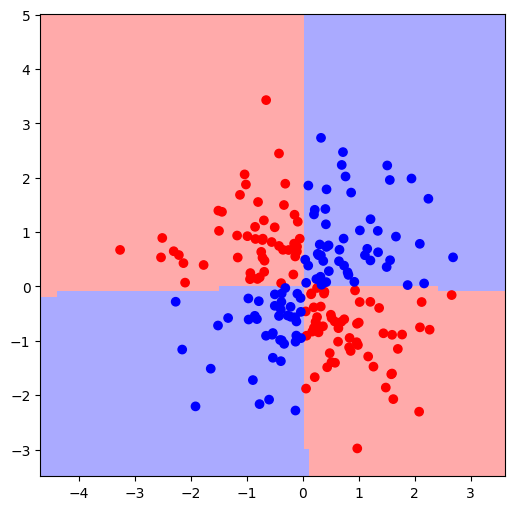




Beginning modelling for the center_surround dataset...


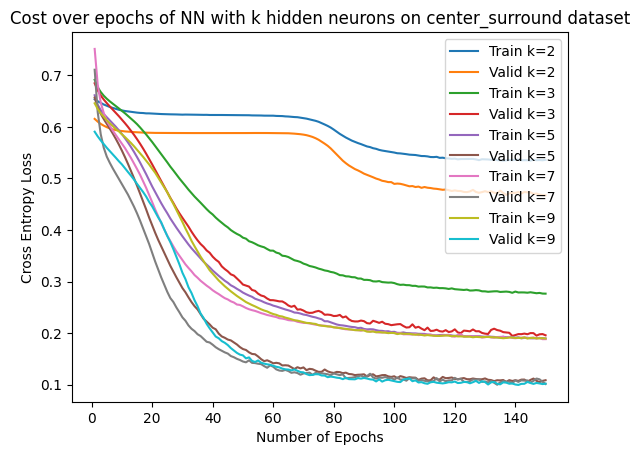

Test accuracy for center_surround dataset for NN with k=9 is 74.50%.


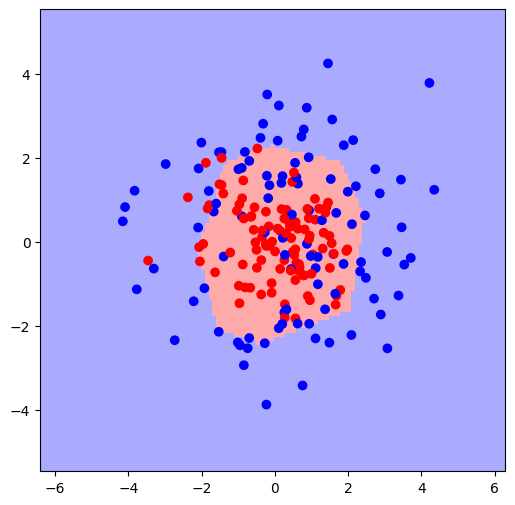




Beginning modelling for the two_gaussians dataset...


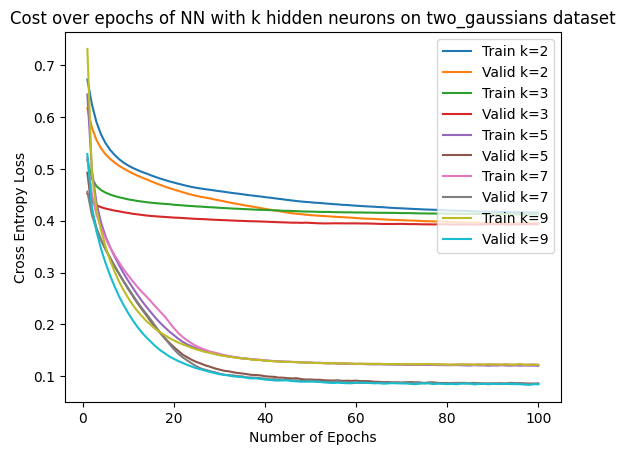

Test accuracy for two_gaussians dataset for NN with k=9 is 91.00%.


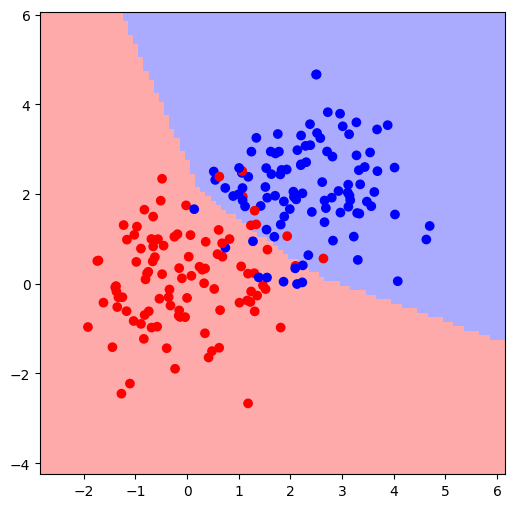




Beginning modelling for the spiral dataset...


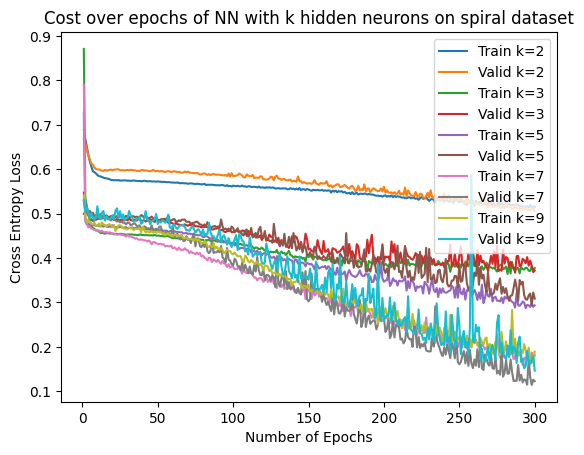

Test accuracy for spiral dataset for NN with k=9 is 99.00%.


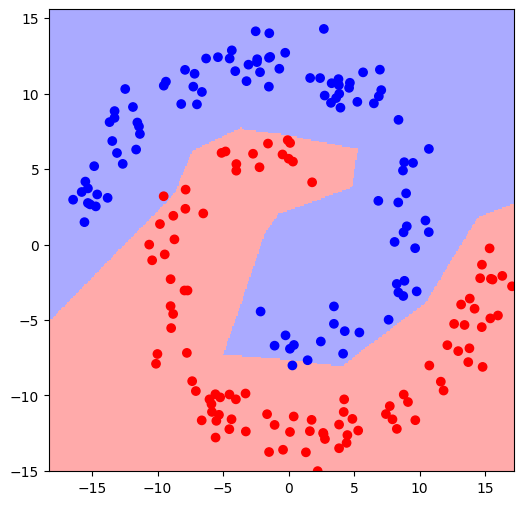

In [4]:
# Question 1

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import ListedColormap
from typing import Union

# set random seed for reproducibility
torch.manual_seed(343)

# define network for Question 1
class Q1_Net(nn.Module):
    def __init__(self,k):
        #initialize parent class nn.Module 
        super(Q1_Net, self).__init__()
        #first linear layer with 3 input features, 'k' output neurons (no bias as it is appended separately)
        self.layer1 = nn.Linear(3, k, bias=False) # bias is appended to all samples from read_data function
        #second linear layer with 'k' input nerons, 2 output nerons (no bias as it is appended separately)
        self.layer2 = nn.Linear(k, 2, bias=False)

    def forward(self, input_vals):
        #convert input values to torch tensor if not already
        input_vals = torch.Tensor(input_vals)
        #first layer activation function with ReLU (rrectified linear unit) function
        activation_1 = F.relu(self.layer1(input_vals)) # chad relu
        #output layer without activation (for compatibility with loss function)
        output = self.layer2(activation_1) 
        return output
    

class CustomDataset(Dataset):
    '''Custom dataset class to handle data for training and validation'''
    def __init__(self, data: torch.Tensor, labels: torch.Tensor):
        #store data and labels, converting labels to long (integer) type
        self.data = data
        self.labels = labels.squeeze(-1).clone().detach().long() # Squeeze and convert to long

    def __len__(self):
        #return length of dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        #return data and label at index 'idx'
        return self.data[idx], self.labels[idx]
    

class Classifier:
    """Classifier to help us train, validate, and predict with a `nn.Module`."""
    def __init__(self, network: nn.Module, train_loader: DataLoader, valid_loader: DataLoader, loss_fn: any):
        #initialize neural network model for training
        self.network = network
        #DataLoader for training data
        self.train_loader = train_loader
        #DataLoader for validation data
        self.valid_loader = valid_loader
        #loss function to compute training/validation error
        #Loss function: calculates the error b/w mode's predictions and actual values (helps optimizer adjust params & improv accuracy)
        self.loss_fn = loss_fn
        #optimizer initialization
        #optimizer: updates the model's parameters during training to minimize the loss
        #           applies an optimization algo to adjust weights based on the gradients calculated during backpropagation
        self.optimizer = None

    def train(self, lr: float, num_epochs: int, optimizer_class: type[torch.optim.Optimizer] = torch.optim.SGD, **optimizer_kwargs) -> tuple[list[float], list[float]]:
        """Trains network and returns train and validation losses"""
        # Define optimizer with model's parameter, a specified learning rate (lr), and additional keyword arguments for fine-tuning the optimization process
        #       Optimizer class is defaulted to sgd
        self.optimizer = optimizer_class(self.network.parameters(), lr=lr, **optimizer_kwargs)
        #lists to store training and validation losses for each epoch
        train_losses, valid_losses = [], []
        #loop over each epoch for training
        for epoch in range(1, num_epochs+1):
            #perform 1 full pass over training data; get avg loss for epoch
            train_loss = self._train_epoch()
            #perofrm 1 full pass over validation data; get avg loss for epoch
            valid_loss = self._valid_epoch()
            #append training and validation for currrent epoch to their list
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

        #return lists of training and validation losses from all epochs
        return train_losses, valid_losses

    @torch.no_grad()
    def evaluate(self) -> float:
        """Evaluates based on validation loader"""
        #call validation epoch method, computes the validation loss for one full pass over the data
        return self._valid_epoch()
    
    @torch.no_grad()
    def predict(self, data: torch.Tensor) -> torch.Tensor:
        """Predict a classes given a batch of data."""
        #ensure that data is a 2-dimensional tensor (batch_size, features)
        assert data.ndim == 2
        #compute predictions using the network and get the index of the maximum value (class label) for each sample
        preds = self.network(data)
        #get the class predictions by taking the index of the maximum value along the last dimension
        return preds.argmax(-1)

    def _train_epoch(self) -> float:
        '''Trains the network for one epoch and returns the avg loss'''
        #accumulator for loss
        running_loss = 0.0
        #set the network in training mode
        self.network.train()
        #iterate over batches in training loader 
        for i, (data, labels) in enumerate(self.train_loader):

            # Remove grads - zero gradients from the previous step to avoid accumulation
            self.optimizer.zero_grad()

            # Forward pass: compute model predictions
            preds = self.network(data)
            #compute the loss b/w predictions and actual labels
            loss = self.loss_fn(preds, labels)

            # Backward pass: calculate gradients
            loss.backward()
            #update model parameters based on calculated gradients
            self.optimizer.step()

            # Update metrics - accumulate loss for this batch
            running_loss += loss.item()

        #return the avg loss over all batches
        return float(running_loss / len(self.train_loader))
    
    @torch.no_grad()
    def _valid_epoch(self) -> float:
        '''Evaluates the network on the validation set for one epoch and returns the avg loss'''
        #accumulator for loss
        running_loss = 0.0
        #set the network in evaluation mode
        self.network.eval()
        #iterate over validation batches
        for i, (data, labels) in enumerate(self.valid_loader):
            # Forward pass: compute predictions and loss
            preds = self.network(data)
            loss = self.loss_fn(preds, labels)
            #accumulate loss for this batch
            running_loss += loss.item()

        #return the avg loss over all validation batches
        return float(running_loss / len(self.valid_loader))


@torch.no_grad()
def custom_plotter(name, model):
    '''Custom plotter function for visualizing decision boundaries and model implementation'''
    #load training and testing data
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    #set up a plot with subplot, scaling the figure size 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    # step size in the mesh
    h = .1 
    #color maps for light background and bold scatter points
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    #define grid range based on the min and max of the training data
    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    #create a mesh grid for plotting decision boundaries
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    #initialize decision boundary grid
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    #initialize grid data for model input format
    grid_data2 = np.zeros([1,3],dtype='float32')
    #iterate through each point in the grid and classify using the model
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            #get grid coordinates
            x = xx[i,j]
            y = yy[i,j]
            #get bias term
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            #convert grid data to torch tensor and make predicitons
            x = torch.from_numpy(grid_data2)
            pred = torch.argmax(model(x), dim=1)
            if (pred[0].item() > 0.5): yh = 1.0
            else: yh = 0.0
            #determine class label and set the decision grid value accordingly
            Z[i,j] = yh
        
    #plot decision boundries and test points
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)
    plt.show()


def train_valid_test_network(
        dataset: str, 
        network: type[nn.Module], 
        batch_size: int, 
        learning_rate: float, 
        num_epochs: int, 
        loss_fn: any, 
        k: Union[int, None] = None,
        optimizer_class: type[torch.optim.Optimizer] = torch.optim.SGD, 
        **optimizer_kwargs
    ) -> float:
    '''Main function for training, validating, and testing, as well as plotting'''

    print(f'Beginning modelling for the {dataset} dataset...')

    #load and prepare training data
    #read hte training data and labels
    train_data, train_labels, _ = read_data(dataset, mode='train')
    #create a custom dataset for training
    train_ds = CustomDataset(data=train_data, labels=train_labels)
    #create a DataLoader for batching and shuffling
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    #load and prepare validation data
    #read the validation data and labels
    val_data, val_labels, _ = read_data(dataset, mode='valid')
    #create a custom dataset for validation
    valid_ds = CustomDataset(data=val_data, labels=val_labels)
    #create a DataLoader for batching without shuffling
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    #initialize hidden neuron configurations if 'k' not provided 
    if k is None: 
        k_vals = [2,3,5,7,9] # if a best k is not given, try different number of hidden neurons 
    else: 
        k_vals=[k] # otherwise make network with just best_k hidden neurons

    #dictionary to store validation losses and classifier objects
    results = {}
    #train and evaluate models with different hidden layer sizes 
    for k_val in k_vals: 
        net = network(k=k_val)
        classifier = Classifier(
            network=net,
            train_loader=train_loader,
            valid_loader=valid_loader,
            loss_fn=loss_fn
        )
        #train the model and capture training/validation loss history
        train_cost_history, valid_cost_history = classifier.train(lr=learning_rate, num_epochs=num_epochs, optimizer_class=optimizer_class, **optimizer_kwargs)
        #evaluate the model on validation data
        val_loss = classifier.evaluate()
        #store classifier object and validation loss in results dictionary
        results[k_val] = {
            'classifier_obj': classifier,
            'val_loss': val_loss
        }
        #plot training and validation losses
        plt.plot([i for i in range(1,num_epochs+1)], train_cost_history, label=f'Train k={k_val}')
        plt.plot([i for i in range(1,num_epochs+1)], valid_cost_history, label=f'Valid k={k_val}')

    #display plot with titles and labels
    plt.title(f'Cost over epochs of NN with k hidden neurons on {dataset} dataset')
    plt.xlabel(f'Number of Epochs')
    plt.ylabel(f'Cross Entropy Loss')
    plt.legend(loc='upper right')
    plt.show()

    # Find the classifier with the minimum validation loss
    min_loss_k = min(results, key=lambda k: results[k]['val_loss'])

    # Retrieve the classifier object with the smallest validation loss
    best_classifier: Classifier = results[min_loss_k]['classifier_obj']

    #load and prepare test data
    test_data, test_data_ys, _ = read_data(name=dataset, mode='test')
    #conduct test inferences; predict classes for test data using the best classifier
    test_inferences = best_classifier.predict(data=test_data)
    # compute accuracy on test data
    test_ys = torch.squeeze(test_data_ys)
    acc = ((test_inferences == test_ys).sum())/len(test_data)
    print(f'Test accuracy for {dataset} dataset for NN with k={k_val} is {acc*100:.2f}%.')

    # plot decision boundaries with test data points
    custom_plotter(name=dataset, model=best_classifier.network)
    print('\n\n')
    return acc

# set hyperparams for each dataset
# batch_size is the number of data points considered for each iterations of SGD
# learning_rate is how significant should a gradient change the weights for an iteration of SGD
# num_epochs is the number of times each data point is used to update weights
datasets = {
    'xor': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':400}, 
    'center_surround': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':150},
    'two_gaussians': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':100},
    'spiral': {'batch_size': 5, 'learning_rate':0.01, 'num_epochs':300}
}

#loop through datasets and train, validate, and test model for each configuration
for dataset, hyperparams in datasets.items():
    test_accuracy = train_valid_test_network(
        dataset=dataset, 
        network=Q1_Net,
        batch_size=hyperparams['batch_size'],
        learning_rate=hyperparams['learning_rate'],
        num_epochs=hyperparams['num_epochs'],
        loss_fn=nn.CrossEntropyLoss()
    )


## Question 2. PyTorch Implementation with MSE (2.0 points)
Repeat Step 1 using mean-squared error as the cost function. You may want to use a sigmoid function as the output layer of your network and apply a threshold of $0.5$ to assign labels at test time.

In [5]:
# TODO code for question 2

## Question 3. Manual Gradients and Updates (3.0 points)
Repeat either Step 1 or Step 2 *without* using a deep learning platform. You can use symbolic differentiation tools like WolramAlpha, Mathematica, etc., to compute gradients. You can also calculate the gradients by hand. You may want to calculate, code and verify gradients for individual components of your model and use the chain rule to build the gradients for specific weights and biases. You may also want to consider using for loops instead of matrix algebra in some parts of your code to avoid the ambiguity of broadcasting. You
may find it helpful to “calibrate” intermediate quantities in your implementation against your PyTorch implementation from Steps 1 or 2.

In [6]:
# TODO code for question 3

## Quetion 4. Regularizers (3.0 points)

Repeat either Step 1 or 2 above, adding two regularizers to your PyTorch implementation. The first regularizer should minimize the norm of the input layer weight matrix. The second regularizer should encourage orthogonality in the intermediate decision boundaries learned in the first layer (note: we discussed this in class as interpreting the output of each hidden node as a single layer perceptron where the weight matrix feeding into a hidden node
can be thought of as the $g(x)$ in the perceptron). In addition to items a through e listed under step one, plot the intermediate decision boundaries of the regularized and unregularized FFNN (see example below). You may find it helpful to work with either the xor data with $k = 3$ for MSE, or the spiral dataset with $k = 3$ for MCE.

In [ ]:
# TODO code for question 4